In [1]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud
import seaborn as sea
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.metrics import roc_curve

In [48]:
dataset = pd.read_csv ('spam.csv', encoding='latin-1')
df = pd.DataFrame (dataset)
df

v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  
...         ...        ...  
5567        NaN        NaN  
5568        NaN        NaN  
5569        NaN        NaN  
5570        NaN        NaN  
5571        NaN        NaN  

[5572 rows x 5 columns]

In [49]:
df.drop (['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df['v1'], df['v2'] = df['v2'], df['v1']
df.rename (columns={'v1': 'email', 'v2': 'classification'}, inplace=True)
replace_classifications = {'ham': 0, 'spam': 1}
df['classification'] = df['classification'].replace (replace_classifications)

In [50]:
df.isna ().sum ()

email             0
classification    0
dtype: int64

In [51]:
from pandas import get_dummies

def one_hot_encoding (df):
    new_cols = pd.DataFrame ()
    for column in df.columns:
        if df[column].dtype == 'int':
            dummy = get_dummies (df[column])
            new_cols = pd.concat ([new_cols, dummy], axis=1)

    return pd.concat ([df, new_cols], axis=1)

df = one_hot_encoding (df)
df

email  classification  0  1
0     Go until jurong point, crazy.. Available only ...               0  1  0
1                         Ok lar... Joking wif u oni...               0  1  0
2     Free entry in 2 a wkly comp to win FA Cup fina...               1  0  1
3     U dun say so early hor... U c already then say...               0  1  0
4     Nah I don't think he goes to usf, he lives aro...               0  1  0
...                                                 ...             ... .. ..
5567  This is the 2nd time we have tried 2 contact u...               1  0  1
5568              Will Ì_ b going to esplanade fr home?               0  1  0
5569  Pity, * was in mood for that. So...any other s...               0  1  0
5570  The guy did some bitching but I acted like i'd...               0  1  0
5571                         Rofl. Its true to its name               0  1  0

[5572 rows x 4 columns]

In [52]:
tfidf = TfidfVectorizer ()

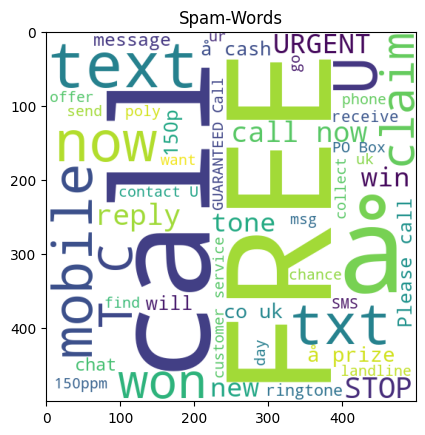

In [53]:
wcloud = WordCloud (width=500, height=500, min_font_size=15, background_color='white')
spam_words = wcloud.generate (df[df['classification'] == 1]['email'].str.cat (sep=' '))
plt.title ('Spam-Words')
plt.imshow (spam_words)

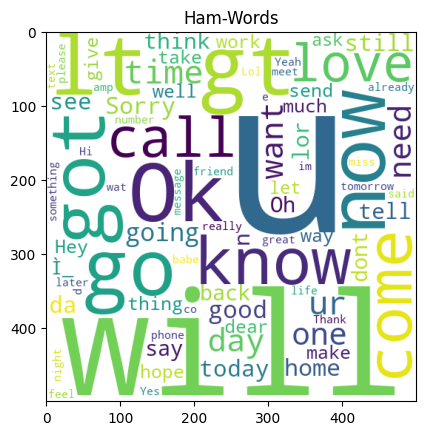

In [54]:
ham_words = wcloud.generate (df[df['classification'] == 0]['email'].str.cat (sep=' '))
plt.title ('Ham-Words')
plt.imshow (ham_words)

<Axes: ylabel='classification'>

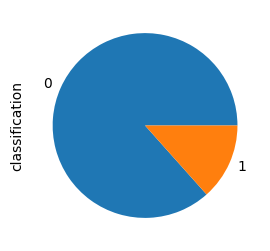

In [55]:
X = tfidf.fit_transform (df.email).toarray ()
yhat = df.classification
yhat.value_counts ().plot (kind='pie', figsize=(4, 3))

In [56]:
X_train, X_test, y_train, y_test = train_test_split (X, yhat, test_size=0.3, random_state=1)

In [108]:
def pipeliner (models):
    model_pipelines = list ()
    for i in range (len (models)):
        sname, mname = f'scaler{i}', str.lower (models[i].__class__.__name__)
        pipe = Pipeline ([
            (mname, models[i])
        ])
        model_pipelines.append (pipe)
    
    for pipe in model_pipelines:
        pipe.fit (X_train, y_train)

    result_mse = dict ()
    for i, model in enumerate (model_pipelines):
        cv_score = cross_val_score (model, X_train, y_train, scoring="neg_mean_squared_error")
        result_mse[cv_score.mean ()] = model
    
    for K, V in result_mse.items ():
        print (K, V)
    
    return result_mse[max (result_mse.keys ())], model_pipelines

model, pipelines = pipeliner ([BernoulliNB (), GaussianNB (), LogisticRegression (), MultinomialNB ()])
model.fit (X_train, y_train)

-0.02358974358974359 Pipeline(steps=[('bernoullinb', BernoulliNB())])
-0.09 Pipeline(steps=[('gaussiannb', GaussianNB())])
-0.046153846153846156 Pipeline(steps=[('logisticregression', LogisticRegression())])
-0.0541025641025641 Pipeline(steps=[('multinomialnb', MultinomialNB())])


Pipeline(steps=[('bernoullinb', BernoulliNB())])

<Axes: >

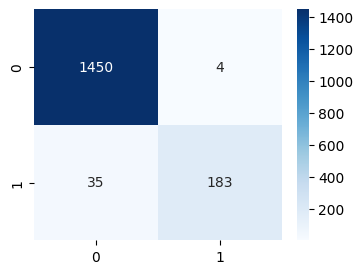

In [109]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict (X_test)
conf_matrix = confusion_matrix (y_test, y_pred)
plt.figure (figsize=(4, 3))
sea.heatmap (conf_matrix, annot=True, fmt='', cmap='Blues')

In [110]:
from sklearn.metrics import classification_report
report = classification_report (y_test, y_pred)
print (report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1454
           1       0.98      0.84      0.90       218

    accuracy                           0.98      1672
   macro avg       0.98      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672



0.7651812240047534
0.9766746411483254


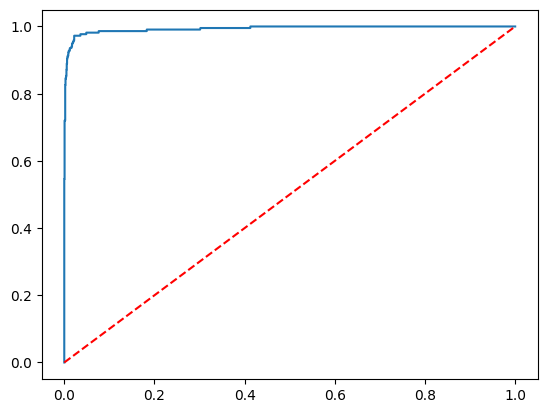

In [111]:
y_pred = model.predict (X_test)
print (r2_score (y_pred, y_test))
print (model.score (X_test, y_test))

y_pred_prob = model.predict_proba (X_test)[:, 1]
f, t, thresholds = roc_curve (y_test, y_pred_prob)
plt.plot(f, t, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

In [112]:
query = tfidf.transform (['Students are building leadership skills and tackling social, economic, and political issues through Prezi — impressive, right? Nonprofit Summa San shares how Prezi can help you engage your students, too.Learn how student leaders everywhere are using Prezi to bring awareness to and solve some of the world’s most pressing problems.We’ll have Q&A time for those who tune in live, but even if you can’t make it, please register so we can send you the recording'])

In [113]:
classify = {
    0: 'not spam',
    1: 'spam'
}

In [114]:
classify[model.predict (query)[0]]

'not spam'

In [115]:
import pickle
pickle.dump (model, open ('spamham.pkl', 'wb'))

In [45]:
import math
def sigmoid (b0, b1, x):
    return 1 / (1 + math.exp -(b0 + b1 * x))

In [46]:
sigmoid ()

TypeError: sigmoid() missing 3 required positional arguments: 'b0', 'b1', and 'x'